# Rétropropagation de l'erreur dans les réseaux de neurones à décharges
### GEI723, Automne 2024
Ce notebook présente comment l'algorithme de la descente du gradient peut être adapté pour la rétropropagation de l'erreur dans les réseaux de neurones à décharges avec des fonctions d'activation non dérivables.

Ce notebook est utilisé dans le cadre du cours GEI723 (Neuro-Computationnel).

- **Encodage de l'entrée** : Les entrées sont encodées sous forme de trains de spikes.
- **Structure du réseau** : Réseau de neurones à décharges avec plusieurs couches, utilisant différentes fonctions d'activation
- **Études menées** : 
  - Impact des fonctions d'activation et des dérivées sur la performance.
  - Analyse des méta-paramètres (nombre de couches, taux d'apprentissage, taille des lots).
  - Comparaison entre réseaux avec et sans apprentissage sur certaines couches.
- **Objectif du code** : Optimisation et analyse de la rétropropagation de l'erreur des réseaux de neurones à décharges.

**Auteurs :**
Clémence Lamballe
Behrouz Nik-Nejad-Kazem-Pour
Jean-Sébastien Giroux


### Sources :

Ce notebook a été inspiré du notebook créé par Ismaël Balafrej, Ph.D. avec Jean Rouat, Ph.D., ing., professeur et adapté par Ahmad El Ferdaoussi, Ph.D. et Arnaud Yarga, étud. Ph.D, dont le copyright et les auteurs sont:

Copyright (c) 2019-2024, Université de Sherbrooke, groupe de recherche NECOTIS. Tous droits réservés.  
Auteurs: Ismael Balafrej, Jean Rouat, adapté par Ahmad El Ferdaoussi et Arnaud Yarga


Ce travail a lui même été adapté et inspiré des articles suivants:
1. Surrogate Gradient Learning in Spiking Neural Networks by Zenke & Ganguli (2018) https://arxiv.org/pdf/1901.09948.pdf
2. SLAYER: Spike Layer Error Reassignment in Time (2018) https://arxiv.org/pdf/1810.08646.pdf
3. Biologically inspired alternatives to backpropagation through time for learning in recurrent neural nets (2019) https://arxiv.org/pdf/1901.09049.pdf


Dans cet exemple de code la gestion du potentiel et de l'intensité du neurone est placé dans la gestion des couches.
Vous pouvez décider de le faire autrement, par exemple dans la phase de propagation avant.

# Packages et imports

In [1]:
%pip install quantities sparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, utils
import torch
import quantities as units
from sparse import COO



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


# Configuration

In [2]:
# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use the GPU unless there is none available.
# If you don't have a CUDA enabled GPU, I recommned using Google Colab,
# available at https://colab.research.google.com. Create a new notebook
# and then go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
# Colab gives you access to up to 12 free continuous hours of a fairly recent GPU.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Préparation des données

In [3]:
# Let's download the MNIST dataset, available at https://www.openml.org/d/554
# You can edit the argument data_home to the directory of your choice.
# The dataset will be downloaded there; the default directory is ~/scikit_learn_data/
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home=None, as_frame=False)
nb_of_samples, nb_of_features = X.shape
# X = 70k samples, 28*28 features; y = 70k samples, 1 label (string)

# Shuffle the dataset
X, y = utils.shuffle(X, y)

# Convert the labels (string) to integers for convenience
y = np.array(y, dtype=int)
nb_of_ouputs = np.max(y) + 1

# We'll normalize our input data in the range [0, 1[.
X = X / pow(2, 8)

# Conversion en décharges

In [4]:
# And convert the data to a spike train using TTFS encoding
dt = 1*units.ms
duration_per_image = 100*units.ms
absolute_duration = int(duration_per_image / dt)

time_of_spike = (1 - X) * absolute_duration  # The brighter the pixel, the earlier the spike
time_of_spike[X < .25] = 0  # "Remove" the spikes associated with darker pixels, which presumably carry less information

sample_id, neuron_idx = np.nonzero(time_of_spike)

# We use a sparse COO array to store the spikes for memory requirements
# You can use the spike_train variable as if it were a tensor of shape (nb_of_samples, nb_of_features, absolute_duration)
spike_train = COO((sample_id, neuron_idx, time_of_spike[sample_id, neuron_idx].astype(int)),
                  np.ones_like(sample_id), shape=(nb_of_samples, nb_of_features, absolute_duration))



# Split entrainement/test/Validation

In [21]:
# Nombre total d'échantillons
print("nb_of_samples =", nb_of_samples)

# 80% pour l'entraînement
nb_of_train_samples = int(nb_of_samples * 0.80)

# 10% pour test
nb_of_test_samples = int(nb_of_samples * 0.10)

# 10% pour validation
nb_of_validation_samples = nb_of_samples - nb_of_train_samples - nb_of_test_samples

# Création des indices
train_indices = np.arange(nb_of_train_samples)
validation_indices = np.arange(nb_of_train_samples, nb_of_train_samples + nb_of_validation_samples)
test_indices = np.arange(nb_of_train_samples + nb_of_validation_samples, nb_of_samples)


print("\ntrain_indices =", train_indices)
print("train_indices.shape =", train_indices.shape)


print("\nvalidation_indices =", validation_indices)
print("validation_indices.shape =", validation_indices.shape)

print("\ntest_indices =", test_indices)
print("test_indices.shape =", test_indices.shape)


total_samples = train_indices.shape[0] + test_indices.shape[0] + validation_indices.shape[0]
print("\ntotal =", total_samples)


nb_of_samples = 70000

train_indices = [    0     1     2 ... 55997 55998 55999]
train_indices.shape = (56000,)

validation_indices = [56000 56001 56002 ... 62997 62998 62999]
validation_indices.shape = (7000,)

test_indices = [63000 63001 63002 ... 69997 69998 69999]
test_indices.shape = (7000,)

total = 70000


# Création du réseau

In [6]:
# We create a 2 layer network (1 hidden, 1 output)
nb_hidden = 128  # Number of hidden neurons

w1 = torch.empty((nb_of_features, nb_hidden), device=device, dtype=torch.float, requires_grad=True)
torch.nn.init.normal_(w1, mean=0., std=.1)

w2 = torch.empty((nb_hidden, nb_of_ouputs), device=device, dtype=torch.float, requires_grad=True)
torch.nn.init.normal_(w2, mean=0., std=.1)


tensor([[ 0.0166, -0.0201, -0.0915,  ...,  0.1204, -0.0279,  0.1034],
        [ 0.0904, -0.0630, -0.0854,  ...,  0.1121, -0.0862, -0.1139],
        [ 0.0663, -0.0444,  0.0240,  ...,  0.0991, -0.0835,  0.0579],
        ...,
        [-0.2037,  0.0690,  0.0162,  ..., -0.0634,  0.0101, -0.0868],
        [ 0.0544, -0.1185,  0.1433,  ..., -0.0279, -0.0658,  0.1325],
        [ 0.0045,  0.0288,  0.0155,  ..., -0.0239, -0.0366, -0.0218]],
       requires_grad=True)

# Classe pour la rétropropagation de l'erreur

In [ ]:




"""
Cette class permet de calculer la sortie d'une fonction lors de la propagation avant et de personaliser la derivée lors de la retropropagation de l'erreur.
Voir cet exemple pour plus de détails : https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
"""
class SpikeFunction(torch.autograd.Function):
    """
    Dans la passe avant, nous recevons un tenseur contenant l'entrée (potential-threshold).
    Nous appliquons la fonction Heaviside et renvoyons un tenseur contenant la sortie.
    """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0 # On génère une décharge quand (potential-threshold) > 0
        return out

    """
    Dans la passe arrière, nous recevons un tenseur contenant le gradient de l'erreur par rapport à la sortie.
    Nous calculons le gradient de l'erreur par rapport à l'entrée en utilisant la dérivée de la fonction ReLu.
    """
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_relu = torch.ones_like(input) # La dérivée de la fonction ReLU
        grad_relu[input < 0] = 0          # La dérivée de la fonction ReLU
        return grad_output.clone()*grad_relu

In [22]:
class SpikeFunction_Leaky_RELU(torch.autograd.Function):
    """
    Variante utilisant Leaky ReLU pour la propagation avant et arrière.
    """
    @staticmethod
    def forward(ctx, input, alpha=0.01):
        """
        Passe avant : spike pour input > 0, sinon applique Leaky ReLU.
        """
        ctx.save_for_backward(input)
        ctx.alpha = alpha
        out = torch.zeros_like(input)
        out[input > 0] = 1.0  # Spike pour les valeurs positives
        out[input <= 0] = alpha * input[input <= 0]  # Leaky ReLU pour les valeurs négatives
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        Passe arrière : applique la dérivée de Leaky ReLU.
        """
        input, = ctx.saved_tensors
        alpha = ctx.alpha
        grad_leaky_relu = torch.ones_like(input)
        grad_leaky_relu[input < 0] = alpha  # La pente alpha pour les valeurs négatives
        return grad_output.clone() * grad_leaky_relu, None


class SpikeFunction_Abs_RELU(torch.autograd.Function):
    """
    Variante utilisant Abs ReLU pour la propagation avant et arrière.
    """
    @staticmethod
    def forward(ctx, input):
        """
        Passe avant : spike pour input > 0, sinon applique la valeur absolue.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0  # Spike pour les valeurs positives
        out[input <= 0] = torch.abs(input[input <= 0])  # Abs pour les valeurs négatives
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        Passe arrière : dérivée constante 1 pour Abs ReLU.
        """
        input, = ctx.saved_tensors
        grad_abs_relu = torch.ones_like(input)  # La dérivée est constante 1
        return grad_output.clone() * grad_abs_relu


In [9]:
def run_spiking_layer(input_spike_train, layer_weights, tau_v=20*units.ms, tau_i=5*units.ms, v_threshold=1.0):
    """Here we implement a current-LIF dynamic in PyTorch"""

    # First, we multiply the input spike train by the weights of the current layer to get the current that will be added
    # We can calculate this beforehand because the weights are constant in the forward pass (no plasticity)
    input_current = torch.einsum("abc,bd->adc", (input_spike_train, layer_weights))  # Equivalent to a matrix multiplication for tensors of dim > 2 using Einstein's Notation

    recorded_spikes = []  # Array of the output spikes at each time t
    membrane_potential_at_t = torch.zeros((input_spike_train.shape[0], layer_weights.shape[-1]), device=device, dtype=torch.float)
    membrane_current_at_t = torch.zeros((input_spike_train.shape[0], layer_weights.shape[-1]), device=device, dtype=torch.float)

    for t in range(absolute_duration):  # For every timestep
        # Apply the leak
        membrane_potential_at_t = float(np.exp(-dt/tau_v))*membrane_potential_at_t # Using tau_v with euler or exact method
        membrane_current_at_t = float(np.exp(-dt/tau_i))*membrane_current_at_t # Using tau_i with euler or exact method

        # Select the input current at time t
        input_at_t = input_current[:, :, t]

        # Integrate the input current
        membrane_current_at_t += input_at_t

        # Integrate the input to the membrane potential
        membrane_potential_at_t += membrane_current_at_t

        # Apply the non-differentiable function
        #recorded_spikes_at_t = SpikeFunction.apply(membrane_potential_at_t - v_threshold)
        recorded_spikes_at_t = SpikeFunction.apply(membrane_potential_at_t - v_threshold)
        #, activation_type='relu'
        #activation_type='leaky_relu', alpha=0.01
        #activation_type='abs_relu'

        
        recorded_spikes.append(recorded_spikes_at_t)

        # Reset the spiked neurons
        membrane_potential_at_t[membrane_potential_at_t > v_threshold] = 0

    recorded_spikes = torch.stack(recorded_spikes, dim=2) # Stack over time axis (Array -> Tensor)
    return recorded_spikes


# Entrainement

In [ ]:
# Set-up training
nb_of_epochs = 20
batch_size = 256  # The backpropagation is done after every batch, but a batch here is also used for memory requirements
number_of_batches = len(train_indices) // batch_size

params = [w1, w2]  # Trainable parameters
optimizer = torch.optim.Adam(params, lr=0.01, amsgrad=True)
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialisation des listes pour stocker les poids
w1_history = []
w2_history = []

for e in range(nb_of_epochs):
    epoch_loss = 0
    for batch in np.array_split(train_indices, number_of_batches):
        # Select batch and convert to tensors
        batch_spike_train = torch.FloatTensor(spike_train[batch].todense()).to(device)
        batch_labels = torch.LongTensor(y[batch, np.newaxis]).to(device)

        # Here we create a target spike count (10 spikes for wrong label, 100 spikes for true label) in a one-hot fashion
        # This approach is seen in Shrestha & Orchard (2018) https://arxiv.org/pdf/1810.08646.pdf
        # Code available at https://github.com/bamsumit/slayerPytorch
        min_spike_count = 10 * torch.ones((batch.shape[0], 10), device=device, dtype=torch.float)
        target_output = min_spike_count.scatter_(1, batch_labels, 100.0)

        # Forward propagation
        layer_1_spikes = run_spiking_layer(batch_spike_train, w1)
        layer_2_spikes = run_spiking_layer(layer_1_spikes, w2)
        network_output = torch.sum(layer_2_spikes, 2)  # Count the spikes over time axis
        loss = loss_fn(network_output, target_output)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print("\nEpoch %i -- loss : %.4f" %(e+1, epoch_loss / number_of_batches))
    # Affichage des 1er, 2e et dernier poids de w1 et w2
    #print(f"Weight evolution - w1: First = {w1.detach().cpu().numpy()[0][0]}, Second = {w1.detach().cpu().numpy()[1][0]}, Last = {w1.detach().cpu().numpy()[-1][0]}")
    print(f"Weight evolution - w2: First = {w2.detach().cpu().numpy()[0][0]}, Second = {w2.detach().cpu().numpy()[1][0]}, Last = {w2.detach().cpu().numpy()[-1][0]}")
    #w1_history.append(w1.detach().cpu().numpy())  
    w2_history.append(w2.detach().cpu().numpy().copy())



Epoch 1 -- loss : 329.8574
Weight evolution - w1: First = -0.11258398741483688, Second = -0.08833757787942886, Last = -0.02453634701669216
Weight evolution - w2: First = 0.3328050673007965, Second = 0.6578252911567688, Last = -0.36469849944114685

Epoch 2 -- loss : 292.1398
Weight evolution - w1: First = -0.11258398741483688, Second = -0.08833757787942886, Last = -0.02453634701669216
Weight evolution - w2: First = 0.5268695950508118, Second = 1.106713891029358, Last = -0.32680296897888184

Epoch 3 -- loss : 286.1379
Weight evolution - w1: First = -0.11258398741483688, Second = -0.08833757787942886, Last = -0.02453634701669216
Weight evolution - w2: First = 0.7428810000419617, Second = 1.4544264078140259, Last = -0.053780850023031235

Epoch 4 -- loss : 284.1332
Weight evolution - w1: First = -0.11258398741483688, Second = -0.08833757787942886, Last = -0.02453634701669216
Weight evolution - w2: First = 0.9212635159492493, Second = 1.725002646446228, Last = 0.4456058144569397

Epoch 5 --

<h1 style="color:red;">Validation</h1>


In [16]:
# Test the accuracy of the model
correct_label_count = 0

# We only need to batchify the test set for memory requirements
for batch in np.array_split(validation_indices,  len(validation_indices) // batch_size):
    validation_spike_train = torch.FloatTensor(spike_train[batch].todense()).to(device)

    # Same forward propagation as before
    layer_1_spikes = run_spiking_layer(validation_spike_train, w1)
    layer_2_spikes = run_spiking_layer(layer_1_spikes, w2)
    network_output = torch.sum(layer_2_spikes, 2)  # Count the spikes over time axis

    # Do the prediction by selecting the output neuron with the most number of spikes
    _, am = torch.max(network_output, 1)
    correct_label_count += np.sum(am.detach().cpu().numpy() == y[batch])

print("Model accuracy on test set: %.3f" % (correct_label_count / len(test_indices)))

Model accuracy on test set: 0.869


# Test

In [14]:
# Test the accuracy of the model
correct_label_count = 0

# We only need to batchify the test set for memory requirements
for batch in np.array_split(test_indices,  len(test_indices) // batch_size):
    test_spike_train = torch.FloatTensor(spike_train[batch].todense()).to(device)

    # Same forward propagation as before
    layer_1_spikes = run_spiking_layer(test_spike_train, w1)
    layer_2_spikes = run_spiking_layer(layer_1_spikes, w2)
    network_output = torch.sum(layer_2_spikes, 2)  # Count the spikes over time axis

    # Do the prediction by selecting the output neuron with the most number of spikes
    _, am = torch.max(network_output, 1)
    correct_label_count += np.sum(am.detach().cpu().numpy() == y[batch])

print("Model accuracy on test set: %.3f" % (correct_label_count / len(test_indices)))

Model accuracy on test set: 0.866


# Graphiques

### Évolution des poids

[1.8595272 1.8595272 1.8595272 1.8595272 1.8595272 1.8595272 1.8595272
 1.8595272 1.8595272 1.8595272 1.8595272 1.8595272 1.8595272 1.8595272
 1.8595272 1.8595272 1.8595272 1.8595272 1.8595272 1.8595272]


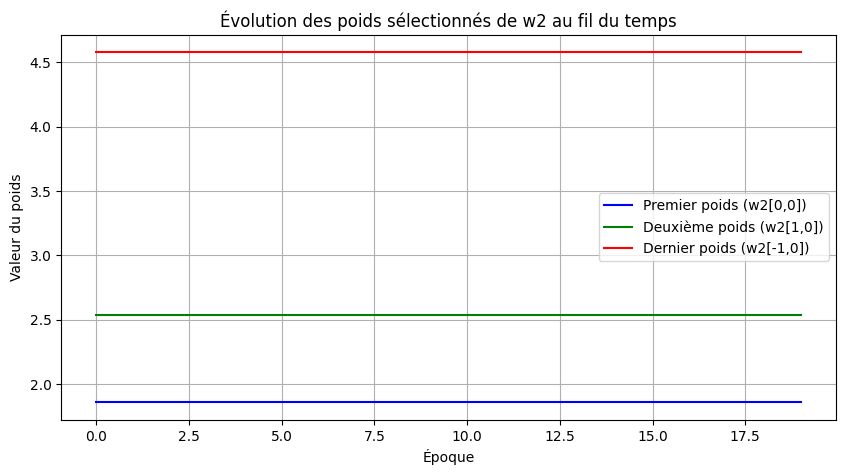

In [19]:
# Convertir w2_history en tableau numpy pour faciliter les manipulations
w2_history = np.array(w2_history)

# Extraire les indices des poids à tracer (premier, deuxième, dernier)
first_weight = w2_history[:, 0, 0]  # Premier poids
second_weight = w2_history[:, 1, 0]  # Deuxième poids
last_weight = w2_history[:, -1, 0]  # Dernier poids
print(first_weight)
# Tracer l'évolution des trois poids
plt.figure(figsize=(10, 5))
plt.plot(first_weight, label="Premier poids (w2[0,0])", color='blue')
plt.plot(second_weight, label="Deuxième poids (w2[1,0])", color='green')
plt.plot(last_weight, label="Dernier poids (w2[-1,0])", color='red')
plt.title("Évolution des poids sélectionnés de w2 au fil du temps")
plt.xlabel("Époque")
plt.ylabel("Valeur du poids")
plt.legend(loc='best')
plt.grid(True)
plt.show()
